In [115]:
import numpy as np
import pandas as pd
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
import gensim
import pyLDAvis
import pyLDAvis.gensim

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
%matplotlib inline
plt.style.use('ggplot')

read data (for some reason the encoding of the data file had a problem and I had to open it in sublime and save it with utf-8 encoding):

In [17]:
data = pd.read_csv('data/20170817_mazub_DataScience.csv',
                  parse_dates=['pubdate', 'user_created_at'])

# func

In [140]:
def clean_text(df, col, stem=False):
    stops = set(stopwords.words("english"))       # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                   # Creating the stemmer model
    
    df[col+'_cleaned'] = df[col].str.lower()
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r"([!]+?)\1+", r"\1")
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r"([a-z]+?)\1+", r"\1\1")
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'@[^\s]+', '|USER|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'#[^\s]+', '|HASHTAG|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'https?\:\/\/[^\s]+', '|URL|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'wwww.[^\s]+', '|URL|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'?', ' |QUESTIOPUNC|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'!', ' |EXCLAMATION|')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'\.{2,}', ' ')
    df[col+'_cleaned'] = df[col+'_cleaned'].str.replace(r'[^a-z0-9\s]', '')
    ## to be added
    # stemming, lemmetizing
    # twitter/known entity replacement
    # spelling correction ???
    
    df[col+'_cleaned'] = df[col+'_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))
    if stem:
        df[col+'_cleaned'] = df[col+'_cleaned'].apply(lambda x: ' '.join([p_stemmer.stem(word) for word in x.split()]))

# generic stats

In [18]:
data.sample(5)

,id,guid,link,pubdate,author,title,description,source,postertimezone,user_id,profile_image_url,user_statuses_count,user_friends_count,user_followers_count,user_created_at,user_bio,user_location,lang
1077,1078,https://twitter.com/DaveRubal/statuses/8983159...,https://twitter.com/DaveRubal/statuses/8983159...,2017-08-17 19:49:00,DaveRubal,RT @KirkDBorne: 19 #Mathemathics &amp; #Statis...,RT @KirkDBorne: 19 #Mathemathics &amp; #Statis...,RoundTeam,-4.0,3.472614e+08,https://pbs.twimg.com/profile_images/296635858...,39282,2675,3715,2011-08-02 14:36:11,"Analytics CTO, Data Scientist, Big Data Archit...","Washington, DC Metro Area",en
382,383,https://twitter.com/calcaware/statuses/8980777...,https://twitter.com/calcaware/statuses/8980777...,2017-08-17 04:03:00,calcaware,RT @jessenleon: How exactly do you set up #Rst...,RT @jessenleon: How exactly do you set up #Rst...,Calcaware,-7.0,7.095650e+17,https://pbs.twimg.com/profile_images/841210424...,143565,128,3054,2016-03-15 02:19:43,Programmer / Hacker,"Austin, TX",en
532,533,https://twitter.com/andrewshamlet/statuses/897...,https://twitter.com/andrewshamlet/statuses/897...,2017-08-16 18:15:00,andrewshamlet,https://t.co/PqcVR5GXTX #code #learn #data #da...,https://t.co/PqcVR5GXTX #code #learn #data #da...,datamining8_andrewshamlet,-4.0,2.442313e+09,https://pbs.twimg.com/profile_images/788026161...,13131,17,2866,2014-04-13 19:08:06,Data Science. Python. Musings. @nyustern @unc ...,"Brooklyn, NY",und
947,948,https://twitter.com/ActivevoiceSw/statuses/898...,https://twitter.com/ActivevoiceSw/statuses/898...,2017-08-17 20:04:00,ActivevoiceSw,Correlation CAN Imply Causation! | Statistics ...,Correlation CAN Imply Causation! | Statistics ...,ActiveVoiceSW,NaN,8.004920e+17,https://pbs.twimg.com/profile_images/800493052...,18166,297,447,2016-11-21 00:12:35,Promote important news about #SoftwareEngineering,"Kansas City, MO",en
477,478,https://twitter.com/seraphinXO/statuses/897987...,https://twitter.com/seraphinXO/statuses/897987...,2017-08-16 22:04:00,seraphinXO,#data #analytics #freedomofspeech #imwithhiq#p...,#data #analytics #freedomofspeech #imwithhiq#p...,Twitter for iPhone,-7.0,1.618468e+07,https://pbs.twimg.com/profile_images/881111464...,134,227,64,2008-09-08 14:09:05,"Insta ‰_Á•ü seraphinXO | ""LinkedIn‰Ûªs attemp...",CT | MI | CA,ro


In [38]:
data.shape

(1627, 18)

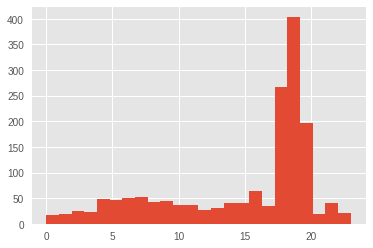

In [30]:
data['pubdate'].dt.hour.hist(bins=24)

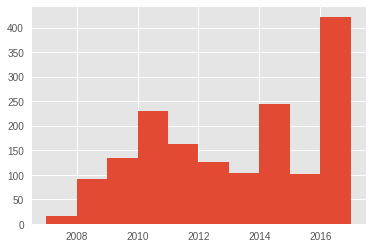

In [29]:
data['user_created_at'].dt.year.hist(bins=10)

In [34]:
data['source'].value_counts().head(10)

Twitter Web Client           260
Twitter for Android          195
datamining8_andrewshamlet    169
Twitter for iPhone           127
realtimeApp_reactjs          105
IFTTT                         89
Buffer                        48
RoundTeam                     40
Calcaware                     39
Hootsuite                     33
Name: source, dtype: int64

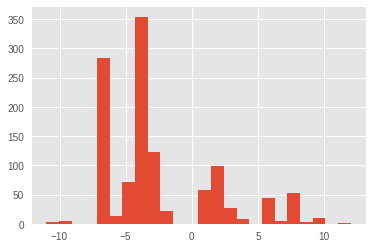

In [36]:
data['postertimezone'].hist(bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f75060c5c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7505f17710>]], dtype=object)

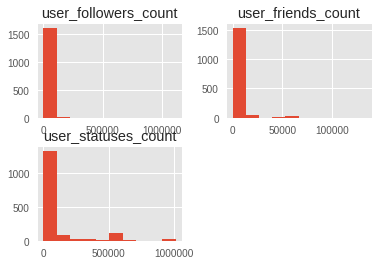

In [52]:
data[['user_statuses_count', 'user_friends_count', 'user_followers_count']].hist()

In [54]:
data['lang'].value_counts().head()

en     1397
und     211
ja        5
es        5
de        3
Name: lang, dtype: int64

In [58]:
data.loc[data.lang=='und', 'author'].value_counts().head()

andrewshamlet    169
lorens_code        6
clairebotai        5
scienceRtBot       4
DataNinjas_        3
Name: author, dtype: int64

# focusing on the en tweets

In [103]:
data_en = data[data.lang=='en'].reset_index(drop=True)

## wordcloud os the user bios

In [104]:
from wordcloud import WordCloud

In [105]:
text = data_en['user_bio'].str.cat(sep=' ').lower() # concat'ing the text
text = re.sub(r'[^a-z0-9\s]', '', text) # removing anything non-alphanumeric or space
wordcloud = WordCloud().generate(text)

(-0.5, 399.5, 199.5, -0.5)

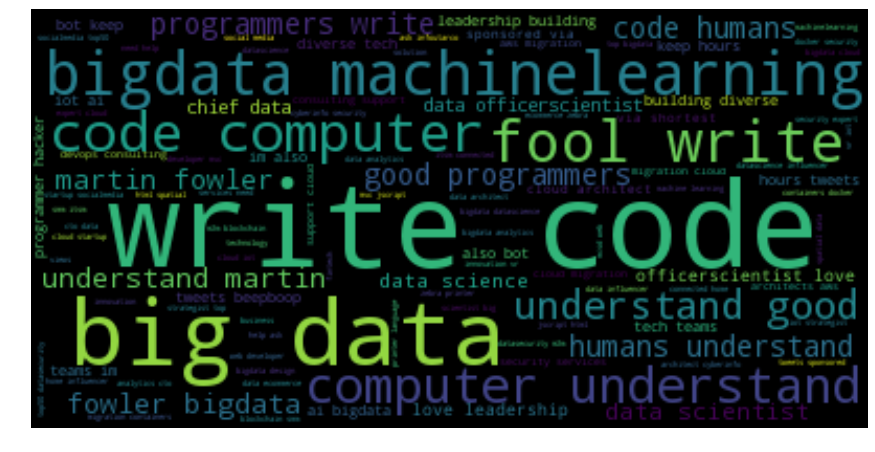

In [106]:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

I'm gonna assume that this dataset is filtered to only include authors who tweet about data/ML/etc judging by the wordcloud

## LDA on tweets

In [141]:
clean_text(data_en, 'description')

In [142]:
documents = data_en['description_cleaned']

In [143]:
train_set = []
for j in range(len(documents)):
    train_set.append(nltk.word_tokenize(documents[j]))

In [144]:
dic = gensim.corpora.Dictionary(train_set)
print(len(dic))
dic.filter_extremes(no_below=20, no_above=0.3)
print(len(dic))

1366
54


In [145]:
corpus = [dic.doc2bow(text) for text in train_set]  # transform every token into BOW

In [148]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda = gensim.models.LdaModel(corpus_tfidf, id2word = dic, num_topics = 4, iterations=20, passes = 10)
corpus_lda = lda[corpus_tfidf]

In [149]:
vis_data = pyLDAvis.gensim.prepare(lda, corpus, dic)
pyLDAvis.display(vis_data)